# SimNet Training for Balancing Robot

This notebook trains a SimNet model using both physics simulation data and real-world data.

In [1]:
import sys
sys.path.append('..')

import torch
import numpy as np
from pathlib import Path
import json
import yaml
from matplotlib import pyplot as plt

from src.balancing_robot.models import SimNet
from src.balancing_robot.environment import BalancerEnv
from src.balancing_robot.training import SimNetTrainer
from src.balancing_robot.visualization import plot_predictions_comparison

## Load Configuration

In [2]:
# Load configurations
with open('../configs/simnet_config.yaml', 'r') as f:
    simnet_config = yaml.safe_load(f)

with open('../configs/env_config.yaml', 'r') as f:
    env_config = yaml.safe_load(f)

# Create directories
log_dir = Path('logs/simnet_training')
log_dir.mkdir(parents=True, exist_ok=True)

## Initialize Models and Environment

In [3]:
# Set random seeds
torch.manual_seed(simnet_config['data_collection']['random_seed'])
np.random.seed(simnet_config['data_collection']['random_seed'])

# Create environment for physics data
env = BalancerEnv(config_path='../configs/env_config.yaml')

# Initialize trainer with config
trainer = SimNetTrainer(
    env=env,
    config_path='../configs/simnet_config.yaml'
)

c:\Users\eyalp\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\eyalp\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


## Collect and Process Physics Data

In [4]:
# Collect physics simulation data
train_data, val_data = trainer.collect_physics_data()

print(f"Collected {len(train_data['states'])} training samples")
print(f"Collected {len(val_data['states'])} validation samples")

Collected 180000 training samples
Collected 20000 validation samples


## Train on Physics Data

In [5]:
# Train on physics data
physics_history = trainer.train(
    train_data=train_data,
    val_data=val_data,
    is_finetuning=False,
    log_dir=log_dir / 'physics'
)

Epoch 1/50 - Train Loss: 280945452.125356 - Val Loss: 280426416.410256
Epoch 2/50 - Train Loss: 279121126.199430 - Val Loss: 278136224.410256
Epoch 3/50 - Train Loss: 276407390.905983 - Val Loss: 275025561.025641
Epoch 4/50 - Train Loss: 272855841.549858 - Val Loss: 271029689.846154
Epoch 5/50 - Train Loss: 268520125.310541 - Val Loss: 266341832.615385
Epoch 6/50 - Train Loss: 263521941.834758 - Val Loss: 261032452.102564
Epoch 7/50 - Train Loss: 257862175.726496 - Val Loss: 255159469.128205
Epoch 8/50 - Train Loss: 251731605.880342 - Val Loss: 248711732.102564
Epoch 9/50 - Train Loss: 245080809.527066 - Val Loss: 241892166.153846
Epoch 10/50 - Train Loss: 238081743.225071 - Val Loss: 234701571.692308
Epoch 11/50 - Train Loss: 230755919.772080 - Val Loss: 227316666.666667
Epoch 12/50 - Train Loss: 223128495.316239 - Val Loss: 219474741.333333
Epoch 13/50 - Train Loss: 215287139.783476 - Val Loss: 211520743.384615
Epoch 14/50 - Train Loss: 207355486.495726 - Val Loss: 203431662.358974
E

## Load and Process Real-World Data

In [ ]:
# # Load real-world log data
# log_file = Path('../data/robot_logs.json')
# with open(log_file, 'r') as f:
#     log_data = json.load(f)

# # Process real data
# real_train_data, real_val_data = trainer.process_real_data(log_data['episodes'])

# print(f"Processed {len(real_train_data['states'])} real training samples")
# print(f"Processed {len(real_val_data['states'])} real validation samples")

## Fine-tune on Real Data

In [7]:
# # Fine-tune on real data
# real_history = trainer.train(
#     train_data=real_train_data,
#     val_data=real_val_data,
#     is_finetuning=True,
#     log_dir=log_dir / 'real'
# )

## Analyze Predictions

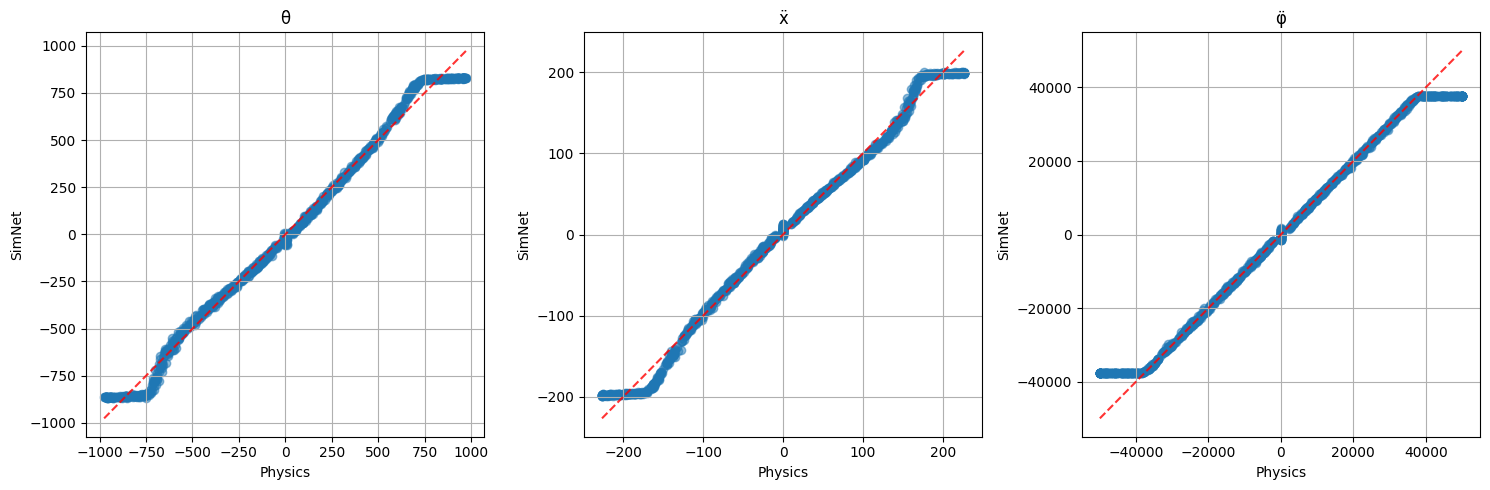

In [8]:
# Compare physics and SimNet predictions
test_states = val_data['states'][:1000]
test_actions = val_data['actions'][:1000]

physics_preds = np.array([env.physics.get_acceleration(state, action) 
                         for state, action in zip(test_states, test_actions)])

simnet_preds = np.array([trainer.simnet.get_accelerations(state, action)
                         for state, action in zip(test_states, test_actions)])

# Plot comparison
fig = plot_predictions_comparison(
    physics_preds=physics_preds,
    simnet_preds=simnet_preds,
    save_path=log_dir / 'prediction_comparison.png'
)
plt.show()

## Save Final Model

In [10]:
# # Save trained SimNet
# torch.save({
#     'state_dict': trainer.simnet.state_dict(),
#     'physics_history': physics_history,
#     'real_history': real_history,
#     'config': simnet_config,
#     'metadata': {
#         'state_dim': env.observation_space.shape[0],
#         'action_dim': env.action_space.shape[0],
#         'hidden_dims': simnet_config['model']['hidden_dims']
#     }
# }, log_dir / 'simnet_final.pt')


# Save trained SimNet
torch.save({
    'state_dict': trainer.simnet.state_dict(),
    'physics_history': physics_history,
    'config': simnet_config,
    'metadata': {
        'state_dim': env.observation_space.shape[0],
        'action_dim': env.action_space.shape[0],
        'hidden_dims': simnet_config['model']['hidden_dims']
    }
}, log_dir / 'simnet_final.pt')